In [44]:
%config IPCompleter.greedy=True

In [45]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [46]:
df = pd.read_csv('../DATA/RSCCASN.csv',index_col='DATE',parse_dates=True) #CHANGE from /Data -> /DATA

In [47]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [48]:
df.columns = ['Sales']

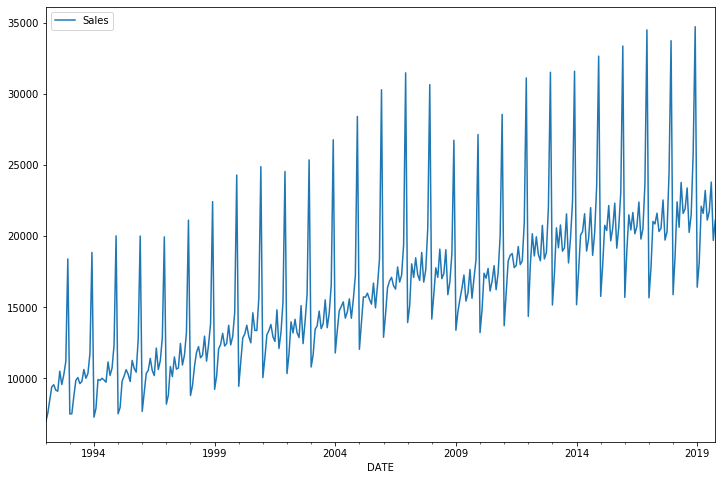

In [49]:
df.plot(figsize=(12,8))

## Train Test Split

In [50]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.(test_size is 18month)

In [51]:
len(df)- 18

316

In [52]:
test_size = 18

In [53]:
test_ind = len(df)- test_size
test_ind

316

In [54]:
train = df.iloc[:test_ind] #[:316] -> 316
test = df.iloc[test_ind:] #[316:] -> 18

In [55]:
train #train_size is 316

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [56]:
test #test_size is 18

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
scaler = MinMaxScaler()

In [59]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [60]:
scaled_train = scaler.transform(train) #316
scaled_test = scaler.transform(test)
scaled_test  #size 18

array([[0.61087714],
       [0.53191258],
       [0.54389341],
       [0.59697212],
       [0.4836625 ],
       [0.52770113],
       [0.68592071],
       [1.00813244],
       [0.34388615],
       [0.40647691],
       [0.55021057],
       [0.53220302],
       [0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
#Test TimeseriesGenerator : It does not care how many generators are create. matter is generator[0], g[1]...
#produce batches for training/validation.(return A Sequence instance.)
data3 = np.array([[i] for i in range(50)])
target3 = np.array([[i] for i in range(50)])

data_gen = TimeseriesGenerator(data3, target3,
#                                length=10, sampling_rate=2,
#                                length=5, sampling_rate=2,                               
                               length=5, sampling_rate=1,
                     
                               batch_size=2) # length =5, len(data_gen) :  23<- 50-5 = 45, np.round(45/2(batch_size)) -> 23
#                                batch_size=1) #length =5, len(data_gen) :  50-5 =45, 45/1(batch_size)-> 45

# assert len(data_gen) == 20
print("len(data_gen) : ",len(data_gen))
batch_0 = data_gen[0]
x, y = batch_0
print("x : \n", x)
print("y : \n", y)
      
# assert np.array_equal(x,
#                       np.array([[[0], [2], [4], [6], [8]],
#                                 [[1], [3], [5], [7], [9]]]))
# assert np.array_equal(y,
#                       np.array([[10], [11]]))

len(data_gen) :  23
x : 
 [[[0]
  [1]
  [2]
  [3]
  [4]]

 [[1]
  [2]
  [3]
  [4]
  [5]]]
y : 
 [[5]
 [6]]


#### Create generator from scaled_train dataset.

In [63]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12 #length of a batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1) #(len:316, len:316, 12,1)

In [64]:
print(len(scaled_train))
len(generator) #(316-12)/1 -> 304

316


304

In [65]:
# What does the first batch look like?
X,y = generator[0] 

In [66]:
print(f'Given the Array: \n{X.flatten()}') #12
print(f'Predict this y: \n {y}') # 1

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [68]:
# We're only using one feature in our time series , column name : sales
n_features = 1

In [69]:
# define model
model = Sequential()
#large neuron for LSTM such as 100
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))#100 output dimension, (12,1)
model.add(Dense(1)) # one predictable output
model.compile(optimizer='adam', loss='mse') #continous variable.

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [71]:
len(scaled_test) #vs. len(scaled_training):316

18

In [72]:
print("your length chosen for your batches : ",length)

your length chosen for your batches :  12


In [73]:
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
#RNN is too noisy in first couple of epochs -> patience need not be default 0
# early_stop = EarlyStopping(monitor='val_loss',patience=2) 
early_stop = EarlyStopping(monitor='val_loss',patience=3) 
# early_stop = EarlyStopping(monitor='val_loss') 

#### Create validation_generator from scaled_test dataset.

In [75]:
#produce batches for training/validation.(return A Sequence instance.)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)#(len:18,len:18,12,1)

In [76]:
len(validation_generator) #create 6 batches : len(scaled_test): 18, length=12-> 18-12 =6, 6/1(batch_size)=> 6 

6

In [77]:
#check validation_generator's first elemnt out of 12
X_vg, y_vg = validation_generator[0]
print(X_vg.shape)
print(f"X_vg[0] length : {len(X_vg[0])} \n X_vg : \n { X_vg}")
print("y_vg : \n", y_vg)

(1, 12, 1)
X_vg[0] length : 12 
 X_vg : 
 [[[0.61087714]
  [0.53191258]
  [0.54389341]
  [0.59697212]
  [0.4836625 ]
  [0.52770113]
  [0.68592071]
  [1.00813244]
  [0.34388615]
  [0.40647691]
  [0.55021057]
  [0.53220302]]]
y_vg : 
 [[0.59040081]]


#### fit_generator model with generator(X,y) and validation_generator(X,y)

In [78]:
# fit model by model.fit_generator(generator, validation_generator=validation_generator)
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 12s 38ms/step - loss: 0.0261 - val_loss: 0.0218
Epoch 2/20
304/304 [==============================] - 11s 38ms/step - loss: 0.0185 - val_loss: 0.0064
Epoch 3/20
304/304 [==============================] - 12s 39ms/step - loss: 0.0128 - val_loss: 0.0210
Epoch 4/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 5/20
304/304 [==============================] - 12s 41ms/step - loss: 0.0035 - val_loss: 4.1736e-04
Epoch 6/20
304/304 [==============================] - 12s 38ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 7/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 8/20
304/304 [==============================] - 12s 40ms/step - loss: 0.0021 - val_loss: 5.6394e-04


In [80]:
losses = pd.DataFrame(model.history.history)

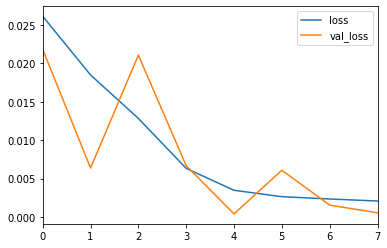

In [81]:
losses.plot()

## Evaluate on Test Data

In [83]:
#test
scaled_train.shape

(316, 1)

In [84]:
len(scaled_train[-length:])

12

In [82]:
first_eval_batch = scaled_train[-length:]  # scaled_train[-12:] #12
# X_vg, y_vg = validation_generator[0] -> X_vg.shape -> (1,12,1)
print(first_eval_batch.shape) #(12, 1) -> need to be (1,12,1) for prediction 
n_input = length #12

(12, 1)


In [85]:
current_batch = first_eval_batch.reshape((1, n_input, n_features)) #(1,12,1) <- X.shape of generator[0] is (1,2,1)

In [86]:
print(current_batch.shape)
current_batch # scaled_train[-12:] , nd.array with 12 elements from scaled_train

(1, 12, 1)


array([[[0.53252977],
        [0.48591345],
        [0.49364653],
        [0.56629393],
        [0.46405751],
        [0.48536886],
        [0.63534708],
        [0.97233517],
        [0.32468051],
        [0.42285071],
        [0.5615016 ],
        [0.49658728]]])

In [87]:
#predict value based on X, training dataset. <- predict based on model trained with TimeseriesGenerator data instance
print(model.predict(current_batch).shape) #2-d(1, 1)
model.predict(current_batch)  #2-d

(1, 1)


array([[0.52994555]], dtype=float32)

In [88]:
#actual y value.
scaled_test[0] 

array([0.61087714])

In [89]:
print( model.predict(current_batch)[0].shape )#1-d no.array 
model.predict(current_batch)[0]

(1,)


array([0.52994555], dtype=float32)

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [90]:
test_predictions = []

first_eval_batch = scaled_train[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))
print("* original current_batch :\n", current_batch) #12
print("==============================================================")

for i in range(len(test)): #18 
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    # model.predict(current_batch)[0], 1-d array(1,)[0.49245596] <-
    # <- model.predict(current_batch),2d (1,1)[[0.49245596]]
    current_pred = model.predict(current_batch)[0]
    print(f"*index {i}: current_pred : {model.predict(current_batch)[0]}")
    print('----------------------')
    # store prediction 
    test_predictions.append(current_pred) #list consist 18 np.array(1,)
    print(f"*test_predictions : \n",test_predictions)
    print("---------------------------------")
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) #[[[0.49245596]]], 3-d(1,1,1)
    print("current_batch :\n", current_batch)
    print("****************************************")

* original current_batch :
 [[[0.53252977]
  [0.48591345]
  [0.49364653]
  [0.56629393]
  [0.46405751]
  [0.48536886]
  [0.63534708]
  [0.97233517]
  [0.32468051]
  [0.42285071]
  [0.5615016 ]
  [0.49658728]]]
*index 0: current_pred : [0.52994555]
----------------------
*test_predictions : 
 [array([0.52994555], dtype=float32)]
---------------------------------
current_batch :
 [[[0.48591345]
  [0.49364653]
  [0.56629393]
  [0.46405751]
  [0.48536886]
  [0.63534708]
  [0.97233517]
  [0.32468051]
  [0.42285071]
  [0.5615016 ]
  [0.49658728]
  [0.52994555]]]
****************************************
*index 1: current_pred : [0.49940792]
----------------------
*test_predictions : 
 [array([0.52994555], dtype=float32), array([0.49940792], dtype=float32)]
---------------------------------
current_batch :
 [[[0.49364653]
  [0.56629393]
  [0.46405751]
  [0.48536886]
  [0.63534708]
  [0.97233517]
  [0.32468051]
  [0.42285071]
  [0.5615016 ]
  [0.49658728]
  [0.52994555]
  [0.49940792]]]
*******

*index 16: current_pred : [0.5072353]
----------------------
*test_predictions : 
 [array([0.52994555], dtype=float32), array([0.49940792], dtype=float32), array([0.5080343], dtype=float32), array([0.56344086], dtype=float32), array([0.4886541], dtype=float32), array([0.50808334], dtype=float32), array([0.6276634], dtype=float32), array([0.9580851], dtype=float32), array([0.36258793], dtype=float32), array([0.44357187], dtype=float32), array([0.5470972], dtype=float32), array([0.5027953], dtype=float32), array([0.5304179], dtype=float32), array([0.51106936], dtype=float32), array([0.5199369], dtype=float32), array([0.56314546], dtype=float32), array([0.5072353], dtype=float32)]
---------------------------------
current_batch :
 [[[0.50808334]
  [0.62766337]
  [0.95808512]
  [0.36258793]
  [0.44357187]
  [0.54709721]
  [0.50279528]
  [0.53041792]
  [0.51106936]
  [0.51993692]
  [0.56314546]
  [0.50723529]]]
****************************************
*index 17: current_pred : [0.5252646]
-

## Inverse Transformations and Compare

In [94]:
print( len(test_predictions) ) 
print( test_predictions[0].shape)
test_predictions # 1 list consists of 18 np.array 

18
(1,)


[array([0.52994555], dtype=float32),
 array([0.49940792], dtype=float32),
 array([0.5080343], dtype=float32),
 array([0.56344086], dtype=float32),
 array([0.4886541], dtype=float32),
 array([0.50808334], dtype=float32),
 array([0.6276634], dtype=float32),
 array([0.9580851], dtype=float32),
 array([0.36258793], dtype=float32),
 array([0.44357187], dtype=float32),
 array([0.5470972], dtype=float32),
 array([0.5027953], dtype=float32),
 array([0.5304179], dtype=float32),
 array([0.51106936], dtype=float32),
 array([0.5199369], dtype=float32),
 array([0.56314546], dtype=float32),
 array([0.5072353], dtype=float32),
 array([0.5252646], dtype=float32)]

In [95]:
true_predictions = scaler.inverse_transform(test_predictions) # scaled value -> actual value 
print(true_predictions.shape)
true_predictions #1 np array, it's shape is (18,1) 

(18, 1)


array([[21534.8202939 ],
       [20693.69167304],
       [20931.296453  ],
       [22457.41502905],
       [20397.48871922],
       [20932.64761353],
       [24226.359972  ],
       [33327.49653769],
       [16925.1219101 ],
       [19155.74346495],
       [22007.24544525],
       [20786.99316549],
       [21547.83116531],
       [21014.89438009],
       [21259.14250278],
       [22449.27851439],
       [20909.28878975],
       [21405.88871479]])

In [96]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/home/ys/anaconda3/envs/tfg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [97]:
print(test.shape)
test

(18, 2)


,Sales,Predictions
DATE,,
2018-05-01,23764,21534.820294
2018-06-01,21589,20693.691673
2018-07-01,21919,20931.296453
2018-08-01,23381,22457.415029
2018-09-01,20260,20397.488719
2018-10-01,21473,20932.647614
2018-11-01,25831,24226.359972
2018-12-01,34706,33327.496538
2019-01-01,16410,16925.121910


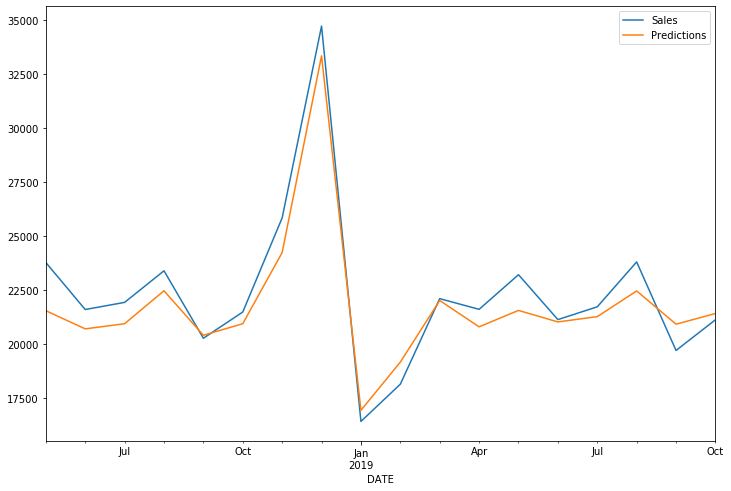

In [98]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [99]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)#instead of train, test, Just use whole df dataset.

In [113]:
scaled_full_data.shape

(334, 1)

In [100]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [101]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 12s 39ms/step - loss: 0.0256
Epoch 2/8
322/322 [==============================] - 12s 37ms/step - loss: 0.0182
Epoch 3/8
322/322 [==============================] - 12s 38ms/step - loss: 0.0083
Epoch 4/8
322/322 [==============================] - 12s 38ms/step - loss: 0.0055
Epoch 5/8
322/322 [==============================] - 12s 38ms/step - loss: 0.0022
Epoch 6/8
322/322 [==============================] - 12s 37ms/step - loss: 0.0016
Epoch 7/8
322/322 [==============================] - 12s 37ms/step - loss: 0.0014
Epoch 8/8
322/322 [==============================] - 12s 37ms/step - loss: 0.0012


In [121]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] #[-12:] #12
current_batch = first_eval_batch.reshape((1, length, n_features)) #pass 1 item per batch, which required at LSTM
#(1,12,1)

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]#(1,)
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) #(1,11,1), (1,1,1)

In [122]:
#before scaler.inverse_transform
forecast

[array([0.665514], dtype=float32),
 array([0.99374306], dtype=float32),
 array([0.32272968], dtype=float32),
 array([0.38396978], dtype=float32),
 array([0.51576674], dtype=float32),
 array([0.5050896], dtype=float32),
 array([0.5617388], dtype=float32),
 array([0.49181005], dtype=float32),
 array([0.5124783], dtype=float32),
 array([0.5830252], dtype=float32),
 array([0.44619155], dtype=float32),
 array([0.4979992], dtype=float32)]

In [123]:
#after inverse_transform
forecast = scaler.inverse_transform(forecast)
print("np.array : ",forecast.shape)
forecast 

np.array :  (12, 1)


array([[25268.91740417],
       [34309.65890026],
       [15827.26622224],
       [17514.06372452],
       [21144.2790823 ],
       [20850.18741941],
       [22410.53320646],
       [20484.416116  ],
       [21053.70207453],
       [22996.8465786 ],
       [19227.90003395],
       [20654.88972473]])

### Creating new timestamp index with pandas.

In [124]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [125]:
#periods=12
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS') #freg='MS'-> monthly, 12 elements
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [126]:
#make DataFrame, forecast_df out of forecast, np.array (12,1) with index:forecast_index, columns:['Forecast'] 
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [127]:
forecast_df

,Forecast
2019-11-01,25268.917404
2019-12-01,34309.658900
2020-01-01,15827.266222
2020-02-01,17514.063725
2020-03-01,21144.279082
2020-04-01,20850.187419
2020-05-01,22410.533206
2020-06-01,20484.416116
2020-07-01,21053.702075
2020-08-01,22996.846579


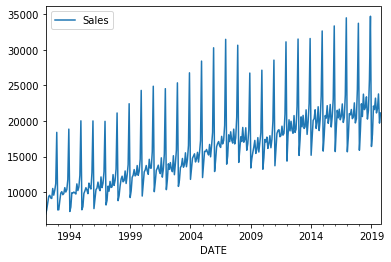

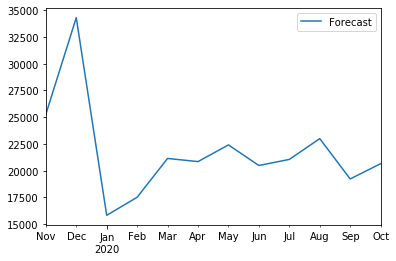

In [128]:
df.plot()
forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

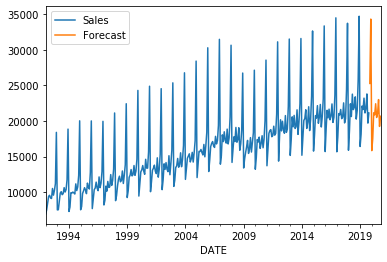

In [129]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

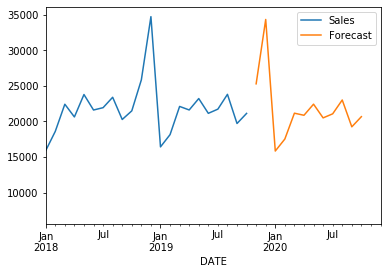

In [130]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# Great Job!